In [10]:
import pandas as pd

# Carregar os dados
df = pd.read_csv('dados_combinados.csv')

# Agregar o número de óbitos por mês e ano
df['DATA'] = pd.to_datetime(df['ANO_OBITO'].astype(str) + '-' + df['MES_OBITO'].astype(str))
series_temporal = df.groupby('DATA').size()

# Visualizar a série temporal
print(series_temporal)

DATA
2010-01-01    6399
2010-02-01    5798
2010-03-01    6030
2010-04-01    6084
2010-05-01    6706
              ... 
2021-08-01    8282
2021-09-01    7205
2021-10-01    7550
2021-11-01    7383
2021-12-01    8117
Length: 144, dtype: int64


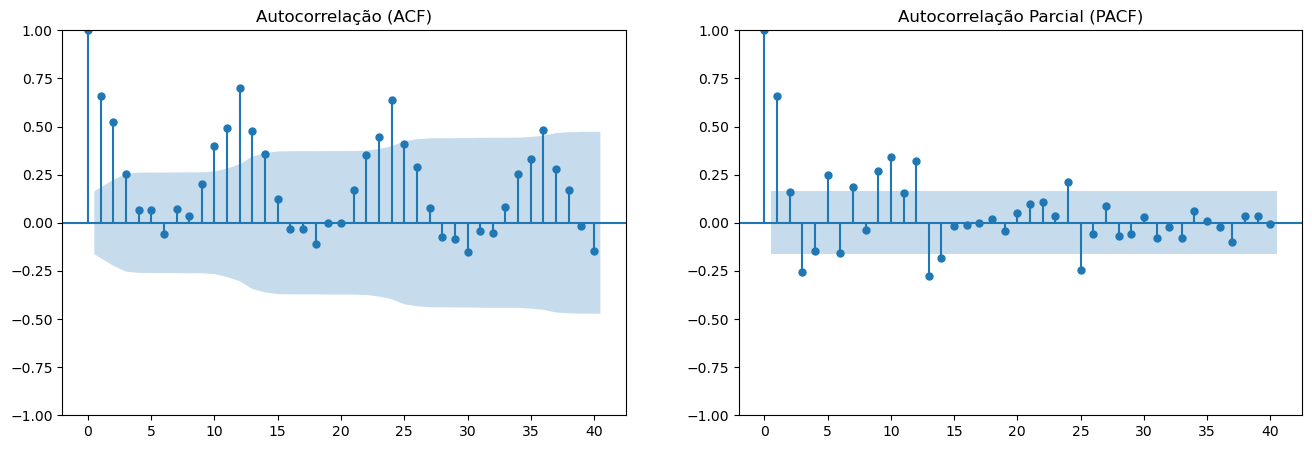

In [11]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Plotando a autocorrelação (ACF) e autocorrelação parcial (PACF)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico de autocorrelação
sm.graphics.tsa.plot_acf(series_temporal, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelação (ACF)')

# Gráfico de autocorrelação parcial
sm.graphics.tsa.plot_pacf(series_temporal, lags=40, ax=axes[1], method='ywm')
axes[1].set_title('Autocorrelação Parcial (PACF)')

plt.show()

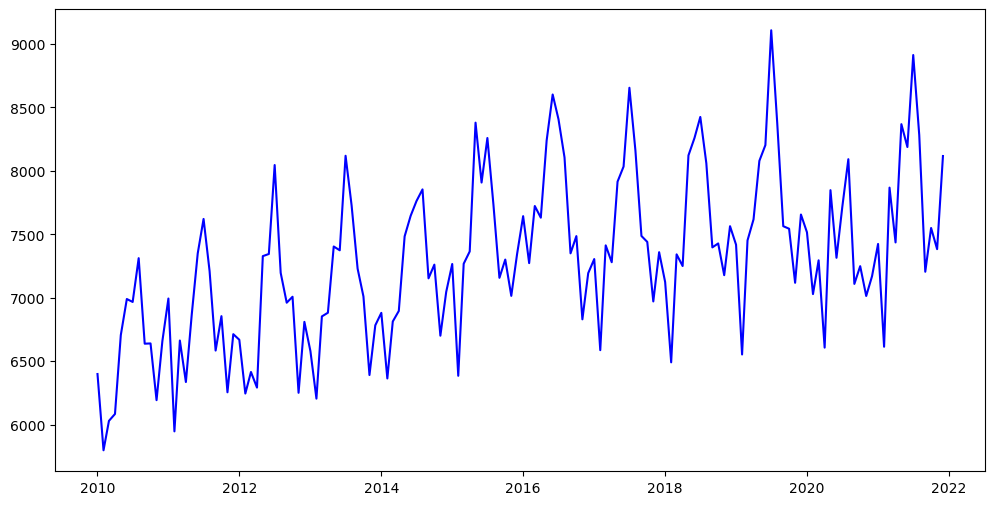

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(series_temporal.index, series_temporal, label='Série Temporal Original', color='blue')

### SARIMA

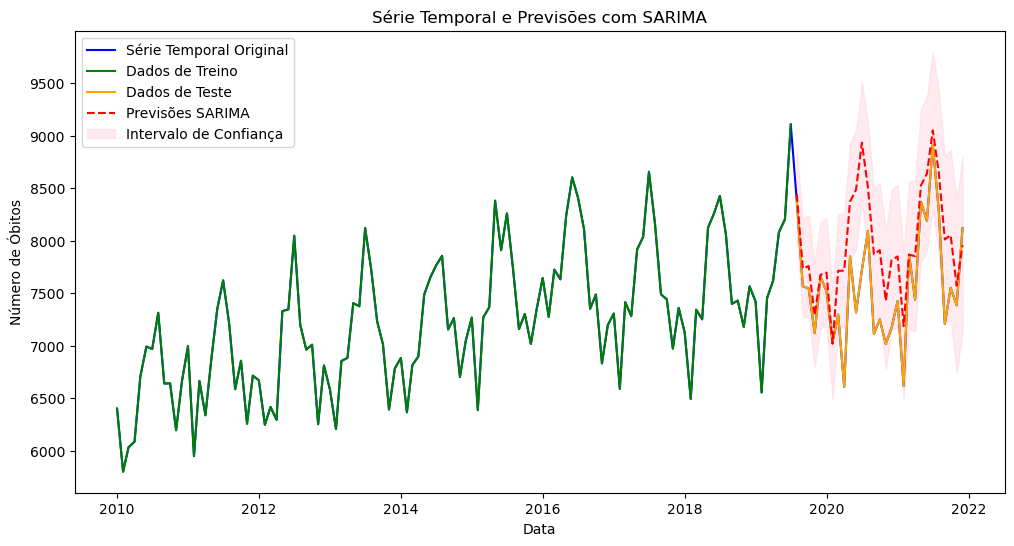

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Carregar os dados
df = pd.read_csv('dados_combinados.csv')

# Criar a coluna de data
df['DATA'] = pd.to_datetime(df['ANO_OBITO'].astype(str) + '-' + df['MES_OBITO'].astype(str))

# Agregar o número de óbitos por mês
series_temporal = df.groupby('DATA').size()

# Definir a frequência como MS (Month Start) e preencher meses faltantes com 0
series_temporal = series_temporal.asfreq('MS', fill_value=0)

# Dividir os dados em treino e teste
train = series_temporal[:int(len(series_temporal)*0.8)]  # 80% para treino
test = series_temporal[int(len(series_temporal)*0.8):]   # 20% para teste

# Ajustar o modelo SARIMA nos dados de treino
# Ordem não sazonal: (p, d, q)
# Ordem sazonal: (P, D, Q, S) onde S é o período sazonal (12 para dados mensais)
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit(disp=False)

# Fazer previsões nos dados de teste
forecast = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean  # Média das previsões
conf_int = forecast.conf_int()  # Intervalo de confiança

# Plotar a série temporal original, os dados de treino, teste e as previsões
plt.figure(figsize=(12, 6))

# Série temporal original
plt.plot(series_temporal.index, series_temporal, label='Série Temporal Original', color='blue')

# Dados de treino
plt.plot(train.index, train, label='Dados de Treino', color='green')

# Dados de teste
plt.plot(test.index, test, label='Dados de Teste', color='orange')

# Previsões
plt.plot(test.index, forecast_mean, label='Previsões SARIMA', color='red', linestyle='--')

# Intervalo de confiança
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Intervalo de Confiança')

# Adicionar título e legendas
plt.title('Série Temporal e Previsões com SARIMA')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.legend()

# Mostrar o gráfico
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error
# Calcular o MSE
mse = mean_squared_error(test, forecast_mean)
print(f'Erro Quadrático Médio (MSE): {mse}')

Erro Quadrático Médio (MSE): 291189.169951514


In [15]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(test, forecast_mean) * 100
print(f'MAPE: {mape:.2f}%')


MAPE: 5.77%


### HOLT WINTERS

Erro Quadrático Médio (MSE): 511179.19
Erro Percentual Absoluto Médio (MAPE): 8.51%


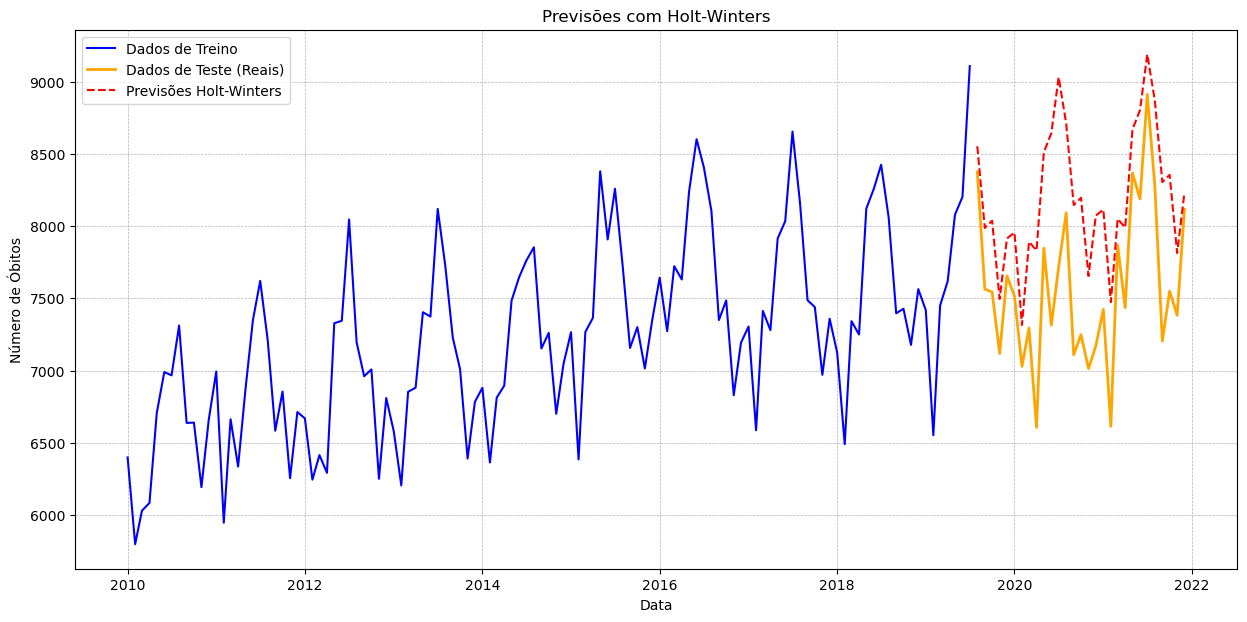

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Carregar os dados
df = pd.read_csv('dados_combinados.csv')

# Criar a coluna de data
df['DATA'] = pd.to_datetime(df['ANO_OBITO'].astype(str) + '-' + df['MES_OBITO'].astype(str))

# Agregar o número de óbitos por mês
series_temporal = df.groupby('DATA').size()

# Definir a frequência como MS (Month Start) e preencher meses faltantes com 0
series_temporal = series_temporal.asfreq('MS', fill_value=0)

# Dividir os dados em treino e teste
train = series_temporal[:int(len(series_temporal)*0.8)]  # 80% para treino
test1 = series_temporal[int(len(series_temporal)*0.8):]   # 20% para teste

# Ajustar o modelo Holt-Winters nos dados de treino
model = ExponentialSmoothing(
    train,
    trend='add',           # Tendência aditiva
    seasonal='add',        # Sazonalidade aditiva
    seasonal_periods=12    # Período sazonal (12 meses)
)
model_fit = model.fit()

# Fazer previsões nos dados de teste
# CORREÇÃO: Usando a variável correta 'test1'
forecast1 = model_fit.forecast(steps=len(test1))

# Calcular o MSE e o MAPE
# CORREÇÃO: Usando a variável correta 'test1'
mse = mean_squared_error(test1, forecast1)
mape = mean_absolute_percentage_error(test1, forecast1) * 100
print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
print(f'Erro Percentual Absoluto Médio (MAPE): {mape:.2f}%')


# --- Bloco de Visualização (Opcional, mas recomendado) ---
plt.figure(figsize=(15, 7))

# Plotar dados de treino e teste
plt.plot(train.index, train, label='Dados de Treino', color='blue')
plt.plot(test1.index, test1, label='Dados de Teste (Reais)', color='orange', linewidth=2)

# Plotar a previsão
plt.plot(test1.index, forecast1, label='Previsões Holt-Winters', color='red', linestyle='--')

# Adicionar título e legendas
plt.title('Previsões com Holt-Winters')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

### LSTM ADAM

In [ ]:
pip install tensorflow

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1880 - val_loss: 0.0565
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0376 - val_loss: 0.0578
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0496 - val_loss: 0.0322
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0344 - val_loss: 0.0364
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0346 - val_loss: 0.0294
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0374 - val_loss: 0.0295
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0373 - val_loss: 0.0294
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0350 - val_loss: 0.0296
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0323 - val_loss: 0.0288
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0283 - val_loss: 0.0290
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0348 - val_loss: 0.0287
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0341 - val_loss: 0.0286
E

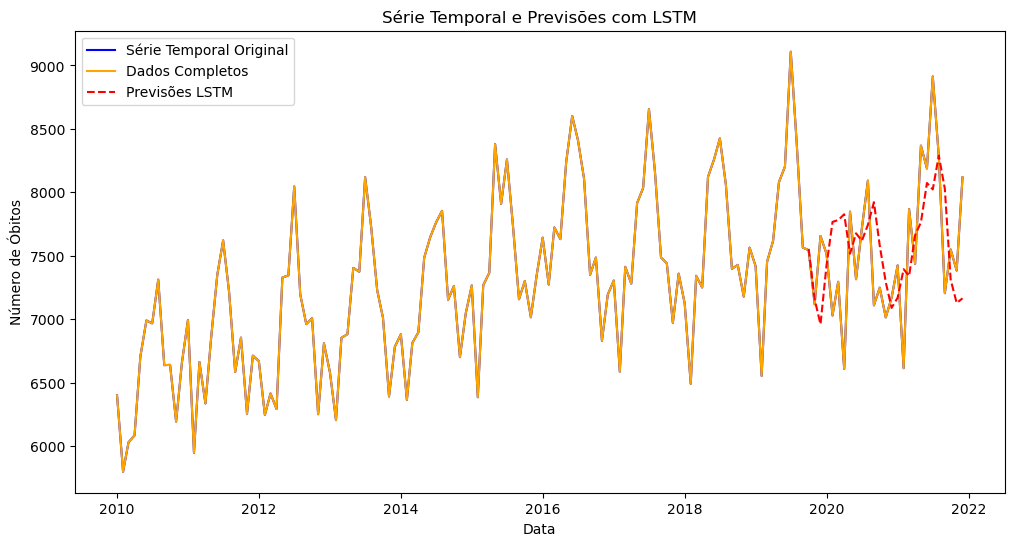

MAPE: 5.77%


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Carregar os dados
df = pd.read_csv('dados_combinados.csv')

# Criar a coluna de data
df['DATA'] = pd.to_datetime(df['ANO_OBITO'].astype(str) + '-' + df['MES_OBITO'].astype(str))

# Agregar o número de óbitos por mês
series_temporal = df.groupby('DATA').size()

# Definir a frequência como MS (Month Start) e preencher meses faltantes com 0
series_temporal = series_temporal.asfreq('MS', fill_value=0)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series_temporal.values.reshape(-1, 1))

# Criar sequências para o LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Número de passos usados para prever
X, y = create_sequences(series_scaled, SEQ_LENGTH)

# Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Construção do modelo LSTM
model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compilar o modelo com o otimizador Adam
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Fazer previsões
predictions = model.predict(X_test)

# Reverter a normalização
predictions = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotar a série temporal inteira
plt.figure(figsize=(12, 6))
plt.plot(series_temporal.index, series_temporal, label='Série Temporal Original', color='blue')
plt.plot(series_temporal.index, series_temporal, label='Dados Completos', color='orange')
plt.plot(series_temporal.index[-len(y_test):], predictions, label='Previsões LSTM', color='red', linestyle='--')
plt.title('Série Temporal e Previsões com LSTM')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.legend()
plt.show()

# Calcular o MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_real, predictions) * 100
print(f'MAPE: {mape:.2f}%')

### LSTM ADAMW

In [37]:
from tensorflow.keras.optimizers import AdamW

# Definir a frequência como MS (Month Start) e preencher meses faltantes com 0
series_temporal = series_temporal.asfreq('MS', fill_value=0)

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series_temporal.values.reshape(-1, 1))

# Criar sequências para o LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Número de passos usados para prever
X, y = create_sequences(series_scaled, SEQ_LENGTH)

# Dividir os dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Construção do modelo LSTM
model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compilar o modelo com o otimizador AdamW
# Você pode simplesmente usar AdamW() ou definir parâmetros como learning_rate e weight_decay
adamw_optimizer = AdamW(learning_rate=0.001, weight_decay=0.004)
model.compile(optimizer=adamw_optimizer, loss='mean_squared_error') # <<< 2. LINHA MODIFICADA

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Fazer previsões
predictions = model.predict(X_test)

# Reverter a normalização
predictions = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.1513 - val_loss: 0.0352
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0478 - val_loss: 0.0355
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0351 - val_loss: 0.0386
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0364 - val_loss: 0.0323
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0407 - val_loss: 0.0315
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0343 - val_loss: 0.0298
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0342 - val_loss: 0.0306
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0332 - val_loss: 0.0296
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0302 - val_loss: 0.0294
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0306 - val_loss: 0.0296
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0337 - val_loss: 0.0293
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0338 - val_loss: 0.0291
E

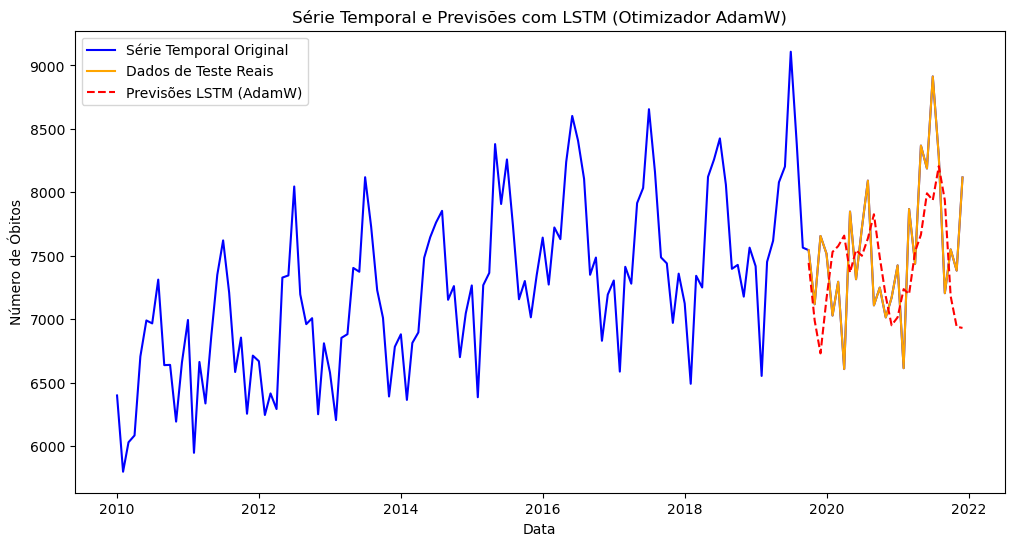

MAPE: 6.16%


In [39]:
# Plotar a série temporal inteira
plt.figure(figsize=(12, 6))
plt.plot(series_temporal.index, series_temporal, label='Série Temporal Original', color='blue')
plt.plot(series_temporal.index[-len(y_test):], y_test_real, label='Dados de Teste Reais', color='orange') # Linha adicionada para clareza
plt.plot(series_temporal.index[-len(y_test):], predictions, label='Previsões LSTM (AdamW)', color='red', linestyle='--')
plt.title('Série Temporal e Previsões com LSTM (Otimizador AdamW)')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.legend()
plt.show()

# Calcular o MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_real, predictions) * 100
print(f'MAPE: {mape:.2f}%')

### LSTM ADAM2

In [108]:
from tensorflow.keras.optimizers import Adam

series_temporal = df.groupby('DATA').size().asfreq('MS', fill_value=0)
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series_temporal.values.reshape(-1, 1))

# 2. Criar sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12 # Aumentado para capturar mais contexto
X, y = create_sequences(series_scaled, SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Construção do modelo (com parâmetros alterados)
model_adam = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(120, return_sequences=True), # Mais unidades
    LSTM(120, return_sequences=False),# Mais unidades
    Dense(60),                        # Mais unidades
    Dense(1)
])

# 4. Compilar o modelo com o otimizador Adam
adam_optimizer = Adam(learning_rate=0.001) # Instância do Adam
model_adam.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# 5. Treinar o modelo (com parâmetros alterados)
history_adam = model_adam.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 6. Fazer previsões e avaliar
predictions_adam = model_adam.predict(X_test)
predictions_adam = scaler.inverse_transform(predictions_adam)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 6. Fazer previsões e avaliar
predictions_adam = model_adam.predict(X_test)
predictions_adam = scaler.inverse_transform(predictions_adam)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 0.1412 - val_loss: 0.0667
Epoch 2/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0543 - val_loss: 0.0295
Epoch 3/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0343 - val_loss: 0.0456
Epoch 4/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0466 - val_loss: 0.0289
Epoch 5/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0338 - val_loss: 0.0353
Epoch 6/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0324 - val_loss: 0.0285
Epoch 7/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0324 - val_loss: 0.0317
Epoch 8/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0349 - val_loss: 0.0284
Epoch 9/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0272 - val_loss: 0.0289
Epoch 10/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0304 - val_loss: 0.0284
Epoch 11/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0303 - val_loss: 0.0280
Epoch 12/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0301 - val_loss: 0.0282


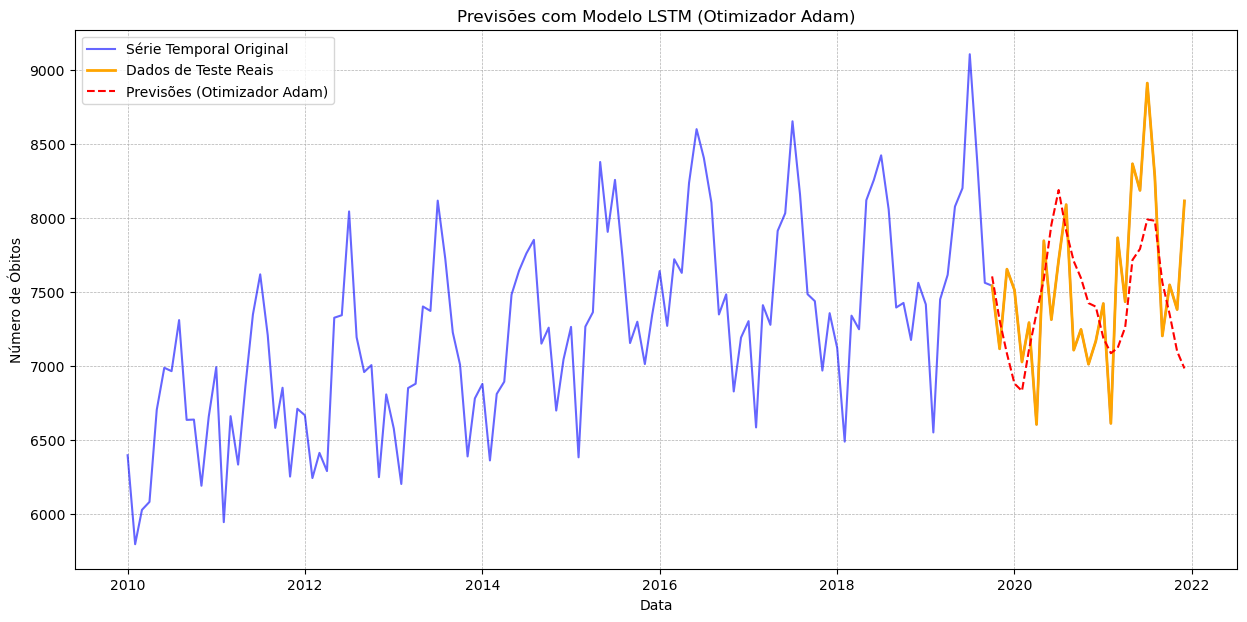

MAPE com Adam: 5.66%


In [110]:
# 7. Plotar resultados no padrão solicitado
plt.figure(figsize=(15, 7))
plt.plot(series_temporal.index, series_temporal, label='Série Temporal Original', color='blue', alpha=0.6)
plt.plot(series_temporal.index[-len(y_test):], y_test_real, label='Dados de Teste Reais', color='orange', linewidth=2)
# Usando as variáveis e rótulos corretos para Adam
plt.plot(series_temporal.index[-len(y_test):], predictions_adam, label='Previsões (Otimizador Adam)', color='red', linestyle='--')
plt.title('Previsões com Modelo LSTM (Otimizador Adam)')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Calcular o MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape_adam = mean_absolute_percentage_error(y_test_real, predictions_adam) * 100
print(f'MAPE com Adam: {mape_adam:.2f}%')

### LSTM ADAMW 2

In [96]:
series_temporal = df.groupby('DATA').size().asfreq('MS', fill_value=0)
scaler = MinMaxScaler(feature_range=(0, 1))
series_scaled = scaler.fit_transform(series_temporal.values.reshape(-1, 1))

# 2. Criar sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 12
X, y = create_sequences(series_scaled, SEQ_LENGTH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Construção do modelo (com parâmetros alterados)
model_adamw = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(120, return_sequences=True),
    LSTM(120, return_sequences=False),
    Dense(60),
    Dense(1)
])

# 4. Compilar o modelo com o otimizador AdamW
adamw_optimizer = AdamW(learning_rate=0.001, weight_decay=0.005) # Instância do AdamW
model_adamw.compile(optimizer=adamw_optimizer, loss='mean_squared_error')

# 5. Treinar o modelo (com parâmetros alterados)
history_adamw = model_adamw.fit(X_train, y_train, epochs=90, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 6. Fazer previsões e avaliar
predictions_adamw = model_adamw.predict(X_test)
predictions_adamw = scaler.inverse_transform(predictions_adamw)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.1736 - val_loss: 0.0792
Epoch 2/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0600 - val_loss: 0.0302
Epoch 3/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0330 - val_loss: 0.0376
Epoch 4/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0380 - val_loss: 0.0294
Epoch 5/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0287 - val_loss: 0.0357
Epoch 6/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0375 - val_loss: 0.0304
Epoch 7/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0295 - val_loss: 0.0290
Epoch 8/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0295 - val_loss: 0.0288
Epoch 9/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0301 - val_loss: 0.0290
Epoch 10/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0275 - val_loss: 0.0289
Epoch 11/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0283 - val_loss: 0.0286
Epoch 12/90
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0302 - val_loss: 0.0304


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


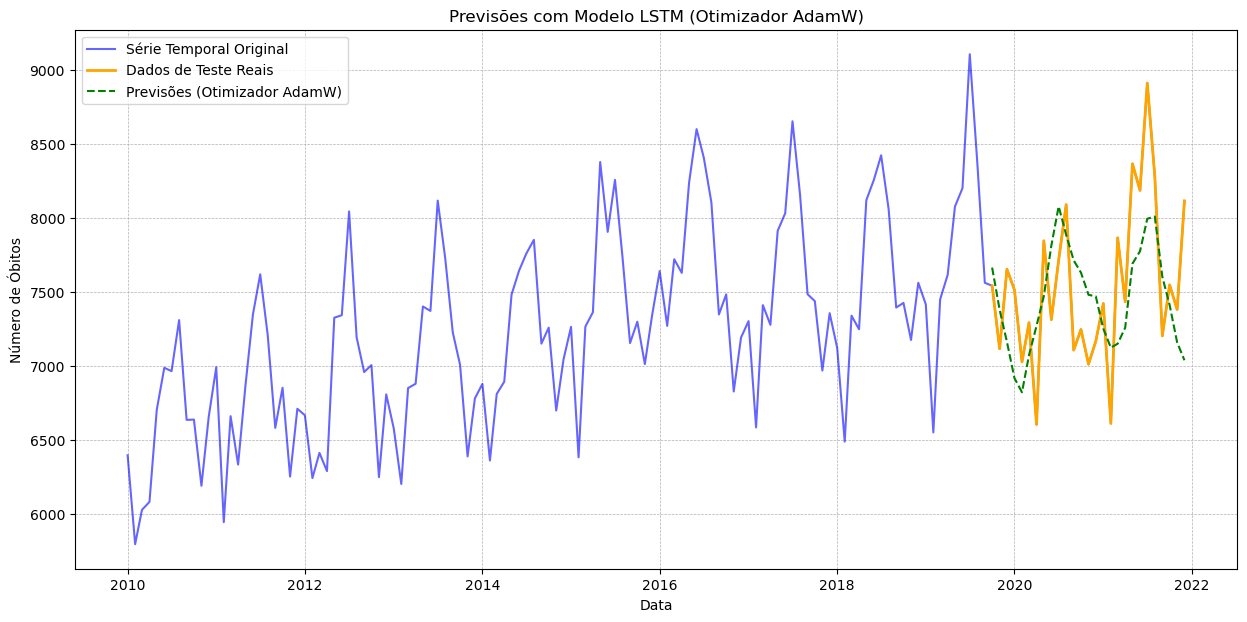

MAPE com AdamW: 5.59%


In [98]:
# 6. Fazer previsões e avaliar
predictions_adamw = model_adamw.predict(X_test)
predictions_adamw = scaler.inverse_transform(predictions_adamw)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Plotar resultados no padrão solicitado
plt.figure(figsize=(15, 7))
plt.plot(series_temporal.index, series_temporal, label='Série Temporal Original', color='blue', alpha=0.6)
plt.plot(series_temporal.index[-len(y_test):], y_test_real, label='Dados de Teste Reais', color='orange', linewidth=2)
# Usando as variáveis e rótulos corretos para AdamW
plt.plot(series_temporal.index[-len(y_test):], predictions_adamw, label='Previsões (Otimizador AdamW)', color='green', linestyle='--')
plt.title('Previsões com Modelo LSTM (Otimizador AdamW)')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Calcular o MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape_adamw = mean_absolute_percentage_error(y_test_real, predictions_adamw) * 100
print(f'MAPE com AdamW: {mape_adamw:.2f}%')